# Notebook para pruebas de train en Colab

## Inicialización

In [1]:
# Importación de librerías
# Gestión de archivos y reporte
import os
import shutil
import logging
import yaml

# Manipulación y análisis de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Procesamiento de imágenes
from PIL import Image

# Machine Learning
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

### Carga de datos almacenados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Cargamos el dataframe desde el .CSV y definimos 'id' como índice
try:
    df_split = pd.read_csv('/content/drive/MyDrive/CV2-PlantVillage/dataframe_splitted.csv').set_index('id')
except FileNotFoundError:
    print(f"⚠️ Error: El archivo 'dataframe.csv' no se encontró en la ubicación actual: {os.getcwd()}")
    print("🚨 Se creará nuevamente al correr las celdas de 'Importación de imágenes' 🚨.")
    df_split = None
except Exception as e:
    print(f"Ocurrió un error al leer el archivo CSV: {e}")
    df_split = None

In [28]:
df_split.head()

,image_path,filename,class,group,tag,split
id,,,,,,
0,Strawberry___healthy/,8f558908-aa1b-4a86-855a-5094c2392e5a___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train
1,Strawberry___healthy/,b8e9ed27-8e37-4214-9206-f8c0ef21cf4d___RS_HL 4...,Strawberry___healthy,Strawberry,healthy,test
2,Strawberry___healthy/,abdd34a0-ab02-41e0-95a3-a014ab863ec2___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train
3,Strawberry___healthy/,d1aee44a-b6bb-45b9-b7b6-5d553add8fd1___RS_HL 2...,Strawberry___healthy,Strawberry,healthy,train
4,Strawberry___healthy/,3d28c3ea-8419-4e09-addd-211e3828e39f___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train


In [4]:
# Cargar variables desde el archivo YAML
try:
    # Verificar si el archivo YAML existe
    yaml_filename = "constants.yaml"
    with open(yaml_filename, "r") as yaml_file:
        constants_data = yaml.safe_load(yaml_file)

    # Acceder a las variables
    ROOT_DIR = constants_data.get("ROOT_DIR")
    DATASET_PATH = constants_data.get("DATASET_PATH")
    SPLITTED_PATH = constants_data.get("SPLITTED_PATH")

    print(f"✅ Se han cargado las variables de configuración desde '{yaml_filename}'")
    print(f" - ROOT_DIR: {ROOT_DIR}")
    print(f" - DATASET_PATH: {DATASET_PATH}")
    print(f" - SPLITTED_PATH: {SPLITTED_PATH}")
except FileNotFoundError:
    print(f"Error: El archivo 'constants.yaml' no se encontró en la ubicación actual: {os.getcwd()}")
    print("Se creará nuevamente al correr el notebook.")
    ROOT_DIR = None
    DATASET_PATH = None
    SPLITTED_PATH = None
except Exception as e:
    print(f"Ocurrió un error al leer el archivo YAML: {e}")

Error: El archivo 'constants.yaml' no se encontró en la ubicación actual: /content
Se creará nuevamente al correr el notebook.


### Funciones necesarias

In [5]:
import os, re

# Busca la carpeta raíz del dataset en el directorio donde fue descargado
def find_path(folder):
    match = re.search(fr"^(.*?)/{folder}/", DATASET_PATH)
    if match:
        prefix = match.group(1)
        path = os.path.join(prefix, f"{folder}/")
        return path
    else:
        print(f'No se ha podido encontrar la carpeta "{folder}" en {DATASET_PATH}')
        return None

In [6]:
# Carga de imagenes en memoria y visualización
def load_image(data: pd.DataFrame, index: int, root: str=ROOT_DIR):
    """
    Carga una imagen PIL desde una fila específica de un DataFrame.

    Args:
        dataframe (pandas.DataFrame): El DataFrame que contiene las rutas de las imágenes.
        index (int): El índice de la fila en el DataFrame para cargar la imagen.
        root_dir (str): El directorio raíz donde se encuentran las imágenes.

    Returns:
        PIL.Image.Image: La imagen cargada como un objeto PIL.Image, o None si ocurre un error.
    """
    if index < 0 or index >= len(data):
        print("Índice fuera de rango.")
        return None

    row = data.iloc[index]
    relative_path = row['image_path']
    filename = row['filename']
    full_path = os.path.join(root, relative_path, filename)

    try:
        img = Image.open(full_path)
        return img
    except FileNotFoundError:
        print(f"Archivo no encontrado: {full_path}")
        return None
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

#### Descarga de dataset de Kaggle

In [7]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", DATASET_PATH)

Path to dataset files: /kaggle/input/plantvillage-dataset


Decidimos en principio trabajar con el dataset con imágenes a color por ser el que contiene mayor información.

In [8]:
# Ruta de acceso al dataset
ROOT_DIR = f'{DATASET_PATH}/plantvillage dataset/color'

# Dataset split

#### Funciones

In [9]:
def dataset_already_exists(path_to_check: str) -> bool | None:
    """
    Verifica si el directorio especificado existe y está vacío.

    Args:
        path_to_check (str): Ruta del directorio a verificar.

    Returns:
        bool: True si el directorio existe y está vacío, False en caso contrario.
    """
    if not os.path.exists(path_to_check):
        # El directorio no existe -> Crea el directorio
        #print(f"☑️ El directorio no existe, aún no ha sido creado:\n > {path_to_check}") # Debugging
        return False # No realiza ninguna acción
    else:
        # Verificar si el directorio está vacío
        try:
            # Explora el contenido del directorio
            content = os.listdir(path_to_check)
            #print(content) # Debugging

            # Si el directorio está vacío, se puede eliminar directamente
            #       -> Elimina sin confirmación
            if not content:
                os.rmdir(path_to_check) # Elimina el directorio vacío
                print(f"☑️ El directorio estaba vacío y se ha eliminado de forma automática:\n > {path_to_check}\n")
                return False

            # Si el directorio contiene sólo archivos ocultos (de sistema)
            #       -> Elimina sin confirmación
            elif all([file.startswith('.') for file in content]):
                shutil.rmtree(path_to_check) # Elimina el directorio y su contenido
                print(f"☑️ El directorio sólo contenía archivos ocutlos, por lo que se ha eliminado de forma automática:\n > {path_to_check}\n")
                return False

            # Si hay archivos visibles en el directorio (dataset ya existe)
            #       -> Solicita permiso para eliminarlos
            else:
                # Input de confirmación del usuario
                confirmacion = input(f"⚠️ El directorio especificado ya existe y contiene archivos. ¿Deseas eliminar todo su contenido y el directorio en sí? [Y/N]: '{path_to_check}'").strip().lower()
                # Verifica la respuesta del usuario
                if confirmacion == 'y':
                    shutil.rmtree(path_to_check) # Elimina el directorio y su contenido
                    print(f"✅ El directorio y su contenido han sido eliminados exitosamente:\n > {path_to_check}\n")
                    return False
                else:
                    print(f"⛔️ La eliminación del directorio ha sido denegada por el usuario:\n  > {path_to_check}")
                    return True

        except OSError as e:
            print(f"❌ Error al eliminar el directorio vacío en {path_to_check}: {e}\n")
            return None
        except Exception as e:
            print(f"‼️ Ocurrió un error inesperado al intentar eliminar el directorio vacío en {path_to_check}: {e}\n")
            return None

In [10]:
def create_ignore_function(df, train_label, filename_col='filename'):
    """
    Crea y devuelve la función 'ignore_files' que tiene acceso al DataFrame
    y sabe qué archivos mantener.
    """
    # Crea un conjunto (set) con los nombres de archivo que SÍ queremos copiar (ej: split == 'train')
    # Usa este conjunto para hacer la búsqueda de forma mucho más rápida
    files_to_keep = set(df[df['split'] == train_label][filename_col])
    #print(f"Archivos a mantener (split='{train_label}'): {files_to_keep}") # Debugging

    def ignore_files(current_dir, files_in_current_dir):
        """
        Función que será llamada por shutil.copytree.
        Decide qué archivos/directorios ignorar en el directorio actual.
        """
        ignore_list = []
        for item in files_in_current_dir:
            # Construye la ruta completa para verificar si es archivo o directorio
            full_path = os.path.join(current_dir, item)

            # Aplicar la lógica de ignorar SOLO los ARCHIVOS de la lista
            if os.path.isfile(full_path):
                # Si el nombre del archivo NO está en el conjunto de archivos a mantener,
                # entonces lo agrega a la lista de ignorados.
                if item not in files_to_keep:
                    # print(f"Ignorando archivo: {item} (en {current_dir})") # Debugging
                    ignore_list.append(item)

        # print(f"Directorio: {current_dir}, Ignorando: {ignore_list}") # Debugging
        return ignore_list

    # Devuelve la función 'ignore_files' configurada
    return ignore_files


## Divisón de datos

Se importa CSV con asignación de splits precalculada y se dividen las imagenes a las carpetas correspondientes.

In [11]:
df_split.sample(5)

,image_path,filename,class,group,tag,split
id,,,,,,
46181,Apple___Black_rot/,f872ce63-a162-44bd-84ac-c7d89c485457___JR_FrgE...,Apple___Black_rot,Apple,Black_rot,train
25592,Grape___Esca_(Black_Measles)/,fc2ac8e3-7ada-41bc-aa54-bd7b6dfc3784___FAM_B.M...,Grape___Esca_(Black_Measles),Grape,Esca_(Black_Measles),train
46988,Apple___healthy/,72053aee-f044-46c5-ab44-322e198c3f1d___RS_HL 7...,Apple___healthy,Apple,healthy,train
1536,Grape___Black_rot/,fccab141-6eac-4889-9ada-7ad19cb346a4___FAM_B.R...,Grape___Black_rot,Grape,Black_rot,train
52401,Soybean___healthy/,63235848-5356-4574-976c-fcf99e83e449___RS_HL 5...,Soybean___healthy,Soybean,healthy,train


### Construcción de carpetas

In [12]:
# Guarda directorio del dataset dividido
path = find_path("plantvillage-dataset")
SPLITTED_PATH = f"{path}splitted/" if path else None
SPLITTED_PATH

No se ha podido encontrar la carpeta "plantvillage-dataset" en /kaggle/input/plantvillage-dataset


In [13]:
splits = df_split['split'].value_counts().index.tolist()
splits

['train', 'test']

In [14]:
verfication = True # Ejecuta el proceso de verificación (punto 2)

print(f"Se inicia proceso de copiado del dataset…")
total_files = len(df_split) # Total de archivos del dataset
print(f" - Total de archivos en el dataset: {total_files}")

# Realiza el proceso de copiado de archivos para cada split
succeeded_process = True
for split in splits:
    # Crea las rutas de origen y destino
    # (Ejemplo: 'train', 'test', 'valid')
    print(f"\n\nIniciando proceso para '{split}' split …")
    source_folder = f'{ROOT_DIR}/'
    destination_folder = f'{SPLITTED_PATH}{split}/'
    total_split = len(df_split[df_split['split'] == split]) # Total de archivos del split
    if dataset_already_exists(destination_folder): # Verifica si el directorio existe y está vacío
        print("  ⨯ El directorio ya existe y contiene archivos, a petición del usuario se omite el proceso de copiado.")
        continue # Si el directorio ya existe, no se hace nada+
    else:
        print(f"🔄 Procesando split '{split.upper()}' ({(total_split/total_files*100):.2f}):")
        print(f"  - Total de archivos a copiar: {total_split}")
    succeeded = False

    try:
        print(f"1. Creando estructura de subcarpetas:")
        # 1. Crea la función para ignorar específica para el split a procesar
        ignore_function = create_ignore_function(df_split, train_label=split, filename_col='filename')
        print(f"    ✔ Función de filtro creada para el split ")

        # 2. Con copytree copia todo el "árbol" de directorios (careptas y subcarpetas)
        # Fitrando con ignore_function todos aquellos archivos que no pertenecen al split deseado
        print(f"    ∞ Copiando contenido del dataset (puede demorar hasta un minuto).")
        shutil.copytree(source_folder, destination_folder, ignore=ignore_function)
        print(f"    ✔ Proceso de copiado del split finalizado.")

        if verfication:
            # Verifica qué se haya copiado adecuadamente (opcional pero útil)
            print(f"2. Se inicia proceso de verificación…")
            copied_files = []
            for root, dirs, files_in_dest in os.walk(destination_folder):
                for name in files_in_dest:
                    copied_files.append(os.path.join(os.path.relpath(root, destination_folder), name).replace('\\', '/')) # Normalizar path
                    #print(f"  - {os.path.join(root, name)}") # Debuggin
            print(f"    ✔ Se crearon un total de {len(os.listdir(destination_folder))} carpetas (para las clases).")
            print(f"    ✔ Se copiaron un total de {len(copied_files)} archivos ({len(copied_files)/total_split*100:.2f}%)")
            # Agregar confirmación de igualdad cantidad split == copiados
            if len(copied_files) == total_split:
                print(f"✅ Se completó satisfactoriamente el subproceso de copiado para el split.\n")
                succeeded = True
            else:
                print(f" ❌ Error: No se pudo copiar correctamente el split '{split.upper()}'\n")
                succeeded = False
        else:
            succeeded = True # Si la verificación está desactivada, se asume que el proceso fue exitoso

    except FileExistsError:
        print(f"Error: La carpeta de destino '{destination_folder}' ya existe.\n")
        pass
    except Exception as e:
        print(f"Ocurrió un error inesperado: {e}\n")

    succeeded_process *= succeeded # Actualiza el estado del proceso
    # (Sólo es 'True' si todos los splits se copian correctamente)

if succeeded_process:
    print("\n\n🌟 El proceso de copiado del dataset ha finalizado con éxito.\n")
else:
    print("\n\n🚫 No se pudo completar satisfactoriamente el proceso de copiado del dataset.\nVerificar que se haya completado la eliminación de las carpetas.\n")

Se inicia proceso de copiado del dataset…
 - Total de archivos en el dataset: 54305


Iniciando proceso para 'train' split …
🔄 Procesando split 'TRAIN' (80.00):
  - Total de archivos a copiar: 43444
1. Creando estructura de subcarpetas:
    ✔ Función de filtro creada para el split 
    ∞ Copiando contenido del dataset (puede demorar hasta un minuto).
    ✔ Proceso de copiado del split finalizado.
2. Se inicia proceso de verificación…
    ✔ Se crearon un total de 38 carpetas (para las clases).
    ✔ Se copiaron un total de 43444 archivos (100.00%)
✅ Se completó satisfactoriamente el subproceso de copiado para el split.



Iniciando proceso para 'test' split …
🔄 Procesando split 'TEST' (20.00):
  - Total de archivos a copiar: 10861
1. Creando estructura de subcarpetas:
    ✔ Función de filtro creada para el split 
    ∞ Copiando contenido del dataset (puede demorar hasta un minuto).
    ✔ Proceso de copiado del split finalizado.
2. Se inicia proceso de verificación…
    ✔ Se crearon un t

----
# Training model

## Dataloader

In [15]:
import tensorflow as tf

In [16]:
# Data laoders setup
def load_from_directory(data_folder):
    """
    Carga un dataset de imágenes desde un directorio específico.

    Args:
        data_folder (str): Ruta al directorio que contiene las imágenes.

    Returns:
        tf.data.Dataset: Dataset de TensorFlow con las imágenes y etiquetas.
    """
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_folder,  # Ruta al directorio de datos
        labels="inferred",  # Las etiquetas se infieren automáticamente desde los nombres de las carpetas
        label_mode="categorical",  # Las etiquetas se codifican como categorías (one-hot encoding)
        class_names=None,  # Las clases se detectan automáticamente
        color_mode="rgb",  # Las imágenes se cargan en modo RGB
        batch_size=128,  # Tamaño de lote para el entrenamiento
        image_size=(256, 256),  # Redimensiona las imágenes a 128x128 píxeles
        shuffle=True,  # Mezcla las imágenes aleatoriamente
        seed=42,  # No se utiliza una semilla específica para la aleatorización
        validation_split=None,  # No se realiza una división de validación aquí
        subset=None,  # No se especifica un subconjunto (train/validation)
        interpolation="bilinear",  # Método de interpolación para redimensionar las imágenes
        follow_links=False,  # No sigue enlaces simbólicos
        crop_to_aspect_ratio=False  # No recorta las imágenes para ajustar la relación de aspecto
    )

    return dataset

In [17]:
# Carga el dataset de imágenes desde el directorio especificado
train_images = ""; test_images = ""; valid_images = ""

print("Cargando datasets desde el directorio…\n")
for split in splits:
    data_folder = f'{SPLITTED_PATH}{split}/'

    # Carga el conjunto de datos desde el directorio especificado
    # Utiliza la función de TensorFlow para crear un dataset de imágenes
    match split:
        case 'train':
            print(f"Cargando dataset de entrenamiento desde:\n > {data_folder}")
            train_images = load_from_directory(data_folder)
        case 'test':
            print(f"Cargando dataset de test desde:\n > {data_folder}")
            test_images = load_from_directory(data_folder)
        case 'valid':
            print(f"Cargando dataset de validación desde:\n > {data_folder}")
            valid_images = load_from_directory(data_folder)
        case _: # En caso de no coincidir con ninguno de los splits
            print(f"⚠️ El split '{split}' no es reconocido. No se cargará ningún dataset.")
            continue # Salta al siguiente split
    print(f"✅ Dataset cargado exitosamente.\n")

Cargando datasets desde el directorio…

Cargando dataset de entrenamiento desde:
 > Nonetrain/
Found 43444 files belonging to 38 classes.
✅ Dataset cargado exitosamente.

Cargando dataset de test desde:
 > Nonetest/
Found 10861 files belonging to 38 classes.
✅ Dataset cargado exitosamente.



In [18]:
print("Resumen de los datasets cargados:")
print(f" - Total de imágenes en el dataset de entrenamiento: {len(train_images)}")
print(f" - Total de imágenes en el dataset de validación: {len(valid_images)}")
print(f" - Total de imágenes en el dataset de test: {len(test_images)}")
print(f"Total de imágenes cargadas: {len(train_images) + len(test_images) + len(valid_images)}\n")

Resumen de los datasets cargados:
 - Total de imágenes en el dataset de entrenamiento: 340
 - Total de imágenes en el dataset de validación: 0
 - Total de imágenes en el dataset de test: 85
Total de imágenes cargadas: 425



In [19]:
print(f"Clases detectadas:")
[print(" -",clase) for clase in train_images.class_names]
print(f"Total de clases: {len(train_images.class_names)}")

Clases detectadas:
 - Apple___Apple_scab
 - Apple___Black_rot
 - Apple___Cedar_apple_rust
 - Apple___healthy
 - Blueberry___healthy
 - Cherry_(including_sour)___Powdery_mildew
 - Cherry_(including_sour)___healthy
 - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 - Corn_(maize)___Common_rust_
 - Corn_(maize)___Northern_Leaf_Blight
 - Corn_(maize)___healthy
 - Grape___Black_rot
 - Grape___Esca_(Black_Measles)
 - Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
 - Grape___healthy
 - Orange___Haunglongbing_(Citrus_greening)
 - Peach___Bacterial_spot
 - Peach___healthy
 - Pepper,_bell___Bacterial_spot
 - Pepper,_bell___healthy
 - Potato___Early_blight
 - Potato___Late_blight
 - Potato___healthy
 - Raspberry___healthy
 - Soybean___healthy
 - Squash___Powdery_mildew
 - Strawberry___Leaf_scorch
 - Strawberry___healthy
 - Tomato___Bacterial_spot
 - Tomato___Early_blight
 - Tomato___Late_blight
 - Tomato___Leaf_Mold
 - Tomato___Septoria_leaf_spot
 - Tomato___Spider_mites Two-spotted_spider_mite
 

----
# Arquitectura del modelo

In [ ]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Input

model = models.Sequential()

# Bloque 1
model.add(Input(shape=(256, 256, 3)))
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Bloque 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Bloque 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Bloque 4
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())

# Capa densa intermedia
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dropout(0.25))

# Capa de salida con 38 neuronas y softmax para multiclase
model.add(layers.Dense(38, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,102,502 (99.57 MB)

 Trainable params: 26,100,518 (99.57 MB)

 Non-trainable params: 1,984 (7.75 KB)

## Entrenamiento

In [21]:
import time

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

start_time = time.perf_counter()

# Definimos el callback para guardar el mejor modelo según la métrica elegida
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',   # Se generará una carpeta con este nombre
    monitor='val_loss',            # Métrica a monitorear ('val_accuracy' es otra opción)
    save_best_only=True,           # Guarda solo si hay mejora
    save_weights_only=False,       # Guarda la arquitectura + pesos
    verbose=1
)

# Ajusta el modelo a tu criterio
with tf.device('/GPU:0'):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

history = model.fit(
    train_images,
    validation_data=test_images,
    epochs=10,
    callbacks=[checkpoint_callback]  # Incorporamos el callback
)

end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.6381 - loss: 1.4038
Epoch 1: val_loss improved from inf to 8.91543, saving model to best_model.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 156s 380ms/step - accuracy: 0.6384 - loss: 1.4022 - val_accuracy: 0.1327 - val_loss: 8.9154
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8988 - loss: 0.3352
Epoch 2: val_loss improved from 8.91543 to 1.05347, saving model to best_model.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 105s 309ms/step - accuracy: 0.8988 - loss: 0.3350 - val_accuracy: 0.7446 - val_loss: 1.0535
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9442 - loss: 0.1743
Epoch 3: val_loss improved from 1.05347 to 0.84877, saving model to best_model.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 108s 318ms/step - accuracy: 0.9442 - loss: 0.1743 - val_accuracy: 0.8104 - val_loss: 0.8488
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9605 - loss: 0.1203
Epoch 4: val_loss improved from 0.

In [23]:
print(f"El entrenamiento tomó {elapsed_time:.2f} segundos")

El entrenamiento tomó 1183.71 segundos


## Guardando resultados

In [24]:
#Recording History in json & pickle
import json
with open('training_hist.json','w') as f:
  json.dump(history.history,f)

import pickle
with open('training_hist.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [25]:
import os

experiment = 'experimento_1' # Completar número de experimento
files = ['best_model.keras','training_hist.json','training_hist.pkl']
destino=f"/content/drive/MyDrive/CV2-PlantVillage/{experiment}/"

def check_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Folder '{folder}' created successfully.")
    else:
        print(f"Folder '{folder}' already exists.")

check_folder(destino)

for file in files:
    try:
        origen=f"/content/{file}"
        !cp -r "$origen" "$destino"
    except:
        print(f"Error al copiar el archivo '{file}'")
    finally:
        print(f"Archivo '{file}' copiado exitosamente.")

Folder '/content/drive/MyDrive/CV2-PlantVillage/experimento_1/' created successfully.
Archivo 'best_model.keras' copiado exitosamente.
Archivo 'training_hist.json' copiado exitosamente.
Archivo 'training_hist.pkl' copiado exitosamente.


---
# Gráficos

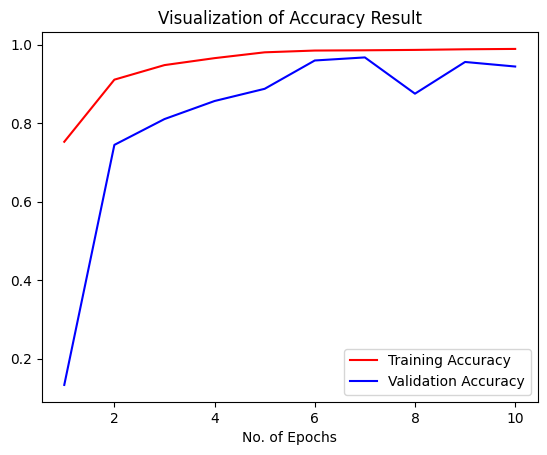

In [26]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1,11)]
plt.plot(epochs,history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [27]:
#Validation set Accuracy
model = tf.keras.models.load_model('best_model.keras')
val_loss, val_acc = model.evaluate(test_images)
print('Validation accuracy:', val_acc)

85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.9669 - loss: 0.0970
Validation accuracy: 0.9675904512405396
